# TP4 : Développement du plateau du Heysel entre 1847 et 1978

## Imports

In [2]:
import json
import requests
import os
import re
import time
from collections import defaultdict
import sys
import spacy
from collections import Counter
from wordcloud import WordCloud
import os
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from IPython.display import Image
import mmap
from difflib import SequenceMatcher
import openpyxl
from openpyxl import Workbook
from openpyxl.utils import get_column_letter
from sklearn.feature_extraction.text import CountVectorizer

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

import unicodedata
import string
from unidecode import unidecode

nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Preparation du corpus d'entrée

## Chargement des noms des rues situées sur le plateau du Heysel et ses abords directs

In [2]:
#obtenir le nom des rue sur nominatim pour le chaque latitude et longitude du plateau du Heysel et les écrire dans une liste

ls=[]

latmmax = 50.90350397899814
longmin = 4.328493534801743
latmin= 50.88509135160375
longmax = 4.354090559446083

while longmin <= longmax:
    longmin=longmin+0.0001000000000000
    x=latmin
    while x <= latmmax:
        url = "https://nominatim.openstreetmap.org/reverse"
        data = {'lat': x, 'lon': longmin,'format': 'json'}
        resp = requests.get(url, data)
        json_list = json.loads(resp.text)
        try:
            ls.append(json_list["address"]["road"] + "\n")
        except KeyError:
            ls.append("erreur rue" + "\n")
        x=x+0.0005000000000

 

## Constitution d'un fichier de mots clés (noms de rues + noms de curiosités touristiques + noms d'événements

In [9]:
#Retirer les doublons, Esplanade, A212 et erreur et on écrit les noms restants dans le fichier rues.txt

ls_back = []

for line in ls:
    if line.lower() not in ls_back and line.lower()!="erreur rue"+"\n" and line.lower()!="esplanade"+"\n" and line.lower()!="a12"+"\n" and line.lower()!="r0"+"\n" and line.lower()!="ro"+"\n" and line.lower()!="36 kv\n":
        ls_back.append(line.lower())

with open("../data/rues.txt", 'w') as file:
    for line in ls_back:
        file.write(line)
        
file.close()

In [10]:
#constitution du fichier de key words reprennant un nom de rue du fichier rue.txt par ligne dans une langue (FR ou NL) et compléter par des noms de monuments, lieux et événements
ls = []
stopwords1=("de lima", "jean-baptiste ", "houba-de", "36 kv", "théophile", "alfred", " straat", "albert", "jan", "generaal", "général", "keizerin", "impératrice", "chemin", "rampe", "rond-point", "chien", "louis", "théophile",  
            "jean-joseph", "eugène", "jean joseph", "jean ", "joseph ", "jozef", "point", "arthur", "ernest", "gustave", "guillaume", "edouard", "leopold",  
            "sentier", "smet", "félix", "felix", "stevens ", "pierre", "emile", "avenue", "place", "rue ","de l'", "de la ", "boulevard", "chaussée", "des ", " la ", "naeyer - ",
           " de ", "du ", "square", "compte", "graaf", "drève", "setter ", " sauge", "treft", " berger", " basset", "disque", "depaire ", "sports", "salu ")
# "beaux arts", "schone ", "houba-de", "grote ","grands", "reper", "moens", "van ", "gros", "belgique", "sports", "hêtres ", "sainte", "saint", "parc", "royal", "koninklijk", "palais", "international ", "anne", "adrien", "léopold", 
with open("../data/rues.txt", 'r') as file:
    for line in file:
        try:
            short= line
            for mot in stopwords1:
                if mot in short:
                    short= short.replace(mot,'')         
            if " - " in short:
                elems = short.split(" - ")
                FR = elems[0]
                NL = elems[1]
            else:
                NL = short
        except KeyError:
            ls.append(line)
        ls.append(FR.strip() + "\n")
        ls.append(NL.strip() + "\n")
file.close()

#ajouter des termes de monuments ou de lieux importants pour notre travail
ls.append("esplanade\n")            
ls.append("atomium\n") 
ls.append("heysel\n") 
ls.append("expositions\n")
ls.append("exposition\n")
ls.append("brussels expo\n") 
ls.append("trademart\n") 
ls.append("brupark\n") 
ls.append("planétarium\n") 
ls.append("stade\n")
ls.append("stevens-delannoy\n")
ls.append("reper-vreven\n")
ls.append("saint-lambert\n")
ls.append("sainte-anne\n")
ls.append("château du stuyvenberg\n")
ls.append("stuyvenberg\n")
ls.append("château de laeken\n")
ls.append("belvédère\n")
ls.append("plateau\n")
ls.append("tour japonaise\n")
ls.append("pavillon chinois\n")
ls.append("moyen-orient\n")
ls.append("eeuwfeest\n")
ls.append("heizel\n")
ls.append("de greef\n")
ls.append("de naeyer\n")
ls.append("du setter\n")
ls.append("de lima\n")
ls.append("houba-de\n")
ls.append("jean-baptiste depaire\n")
ls.append("keizerin\n")
ls.append("impératrice\n")
ls.append("chien de berger\n")
ls.append("du basset \n")
ls.append("exposition universelle\n")
ls.append("exposition internationalle\n")
ls.append("expositions universelles\n")
ls.append("expositions internationalles\n")
ls.append("expo bruxelles\n")
ls.append("alberteum\n")
ls.append("palais de la science\n")
ls.append("stade du centenaire\n")
ls.append("stade du heysel\n")
ls.append("stade roi baudouin\n")          
ls.append("parc d’osseghem\n")
ls.append("parc de laeken\n")          
ls.append("parc sobieski\n")          
ls.append("serres royales\n")          
ls.append("expo 58\n") 
ls.append("jardin colonial\n") 
ls.append("jardin du fleuriste\n")           
ls.append("heyselbeek\n")           
ls.append("étangs d’osseghem\n")  
ls.append("étangs du stuyvenberg\n")
ls.append("plateau d’osseghem\n")          
ls.append("grand palais\n")          
ls.append("meli heysel\n") 
ls.append("du disque\n")
ls.append("des sports\n")
ls.append("ernest salu\n")
          

ls.sort()
           
with open("../data/key_words.txt", 'w') as file:
    for line in ls:
        if line!="\n":
            file.write(line)     
file.close()

ls=[]
with open("../data/key_words.txt", 'r') as file:
    for line in file:
        if line not in ls and line!="\n":
            ls.append(line)

with open("../data/key_words.txt", 'w') as file:
    for line in ls:
        file.write(line)

In [11]:
#vérifier le contenu du fichier de recherche
fichier = open("../data/key_words.txt", "r")
print (fichier.read())
fichier.close()

abelenlaan
adrien bayet
adrien bayetlaan
alberteum
amandelbomenlaan
amandiers
amforalaan
amnesty international
amnesty internationalplein
amphore
antwerpselaan
athlètes
atletenlaan
atomium
atomiumlaan
atomiumplein
baisieux
baisieuxstraat
belgieplein
belgique
belvédère
bergdal
bieslookstraat
binnenhof
boechoutlaan
bonaventure
bonaventurestraat
bouchout
boxer
boxerweg
brachet
brachetlaan
brupark
brussels expo
centenaire
ceuninck
ceunincklaan
championnat
charlotte
charlottelaan
chien de berger
chrysantenstraat
chrysanthèmes
château de laeken
château du stuyvenberg
ciboulette
clementina
cloître
clémentine
cocker
cockerweg
cresson
crocq
crocqlaan
croix-rouge
dashondweg
de greef
de laubespin -laubespinstraat
de lima
de naeyer
de naeyerlaan
depairelaan
des sports
dikkelindelaan
du basset 
du disque
du setter
dynastie
ebbebomenlaan
eeuwfeest
eeuwfeestlaan
ernest salu
esplanade
expo 58
expo bruxelles
exposition
exposition internationalle
exposition universelle
expositions
expositions internatio

## Amélioration de la qualité des bulletins communaux à l'aide du fichier de mots clé

In [12]:
#on met les fichiers txt en minuscule pour faciliter les recherches/comparaisons et on les sauvegarde sous data/tmp
ls = []

temp_path = '../data/tmp'
txt_path = '../data/txt'

for f in os.listdir(txt_path): 
    if os.path.isfile(os.path.join(txt_path, f)):
        bulletin=txt_path + "/" + f
        with open(bulletin, 'r') as filein:
            for line in filein:
                ls.append(line.lower())
    filein.close()
    bulletin_clean=temp_path + "/" + f   
    with open(bulletin_clean, 'w') as fileout:
        for line in ls:
            fileout.write(line)
    fileout.close()
    ls = []



## Test de différentes approches d'amélioration

### Approche 1 : gestion des espaces uniquement

In [13]:
#on fait une liste de mots à corriger importants pour notre travail sur base du fichier rues et on les mets dans fichier correction.txt - ici on va corriger uniquement les espaces dans les mots à rechercher
ls = []
mot=[]
with open("../data/key_words.txt", 'r') as file:
    for line in file:
        string1=line.strip()
        for lettre in string1:
            mot.append(lettre)
        ls.append(" ".join(mot)+" = "+ string1 + "\n")
        mot=[]


with open("../data/correction_espaces.txt", 'w') as fileout:
    for line in ls:
        fileout.write(line)



In [14]:
#on parcourt les bulletins et on voit le nombre de corrections qui seraient faites avec les mots de corrections_espaces.txt

txt_path = '../data/tmp'
ls=[]
compteur=0

with open("../data/correction_espaces.txt", 'r') as filecorr:
    for corr in filecorr:
        try:
            elems = corr.split("=")
            erreur = elems[0]
            correction = elems[1]    
            for f in os.listdir(txt_path): 
                if os.path.isfile(os.path.join(txt_path, f)):
                    bulletin=txt_path + "/" + f
                    with open(bulletin, 'r') as filein:
                        for line in filein:
                            if erreur in line:
                                compteur+=1
                    filein.close()
            print(str(compteur) + " = " + correction)
            compteur=0
        except KeyError:
            print("erreur")
                                

0 =  abelenlaan

0 =  adrien bayet

0 =  adrien bayetlaan

2 =  alberteum

0 =  amandelbomenlaan

4 =  amandiers

0 =  amforalaan

0 =  amnesty international

0 =  amnesty internationalplein

4 =  amphore

1 =  antwerpselaan

12 =  athlètes

0 =  atletenlaan

62 =  atomium

0 =  atomiumlaan

0 =  atomiumplein

13 =  baisieux

0 =  baisieuxstraat

0 =  belgieplein

1238 =  belgique

6 =  belvédère

0 =  bergdal

0 =  bieslookstraat

0 =  binnenhof

1 =  boechoutlaan

1 =  bonaventure

0 =  bonaventurestraat

7 =  bouchout

0 =  boxer

0 =  boxerweg

12 =  brachet

0 =  brachetlaan

0 =  brupark

0 =  brussels expo

181 =  centenaire

7 =  ceuninck

0 =  ceunincklaan

34 =  championnat

41 =  charlotte

1 =  charlottelaan

0 =  chien de berger

0 =  chrysantenstraat

33 =  chrysanthèmes

0 =  château de laeken

0 =  château du stuyvenberg

0 =  ciboulette

0 =  clementina

21 =  cloître

65 =  clémentine

12 =  cocker

0 =  cockerweg

4 =  cresson

23 =  crocq

0 =  crocqlaan

84 =  croi

### Approche 2 : gestion des erreurs avec une formule RegEx

In [15]:
#on fait une liste de mots à corriger dans le corpus sur base des noms de rues et on les adaptes avec une formule Regex qui gère les espaces erronés, les é/è/ê/ê, les a/â, les tirets, les i/l/î/ï, ... on les mets dans fichier correction.txt - ici on va corriger les espaces dans les mots à rechercher
ls = []
mot=[]
with open("../data/key_words.txt", 'r') as file:
    for line in file:
        string1=line.strip()
        for lettre in string1:
            if lettre == "é":
                lettre = "(e|é)"
            if lettre == "â":
                lettre = "(a|â)"
            if lettre == "ë":
                lettre = "(e|ë)"
            elif lettre == "i":
                lettre = "(i|l)"
            elif lettre == "ï":
                lettre = "(ï|i|l)"
            elif lettre == "l":
                lettre = "(i|l)"
            elif lettre == "è":
                lettre = "(e|è)"
            elif lettre == "ê":
                lettre = "(ê|e)"
            else:
                lettre = lettre
            mot.append(lettre)
        ls.append(("(\_|\.|\-|\s)*".join(mot)).strip() +" = "+ string1 + "\n") 
        mot=[]

with open("../data/correction_regex.txt", 'w') as fileout:
    for line in ls:
        fileout.write(line)
        

In [16]:
#on parcourt les bulletins et on voit le nombre de corrections qui seraient faites.
txt_path = '../data/tmp'
compteur=0
listecorrection=[]
corrigé=''

with open("../data/correction_regex.txt", 'r') as filecorr:
    for corr in filecorr:
        try:
            elems = corr.split("=")
            erreur = elems[0].strip()
            correction = elems[1].strip() 
            for f in os.listdir(txt_path): 
                if os.path.isfile(os.path.join(txt_path, f)):
                    bulletin=txt_path + "/" + f
                    with open(bulletin, 'r') as filein:
                        for line in filein:
                            z=re.search(erreur,line) 
                            if z:
                                if (z.group()).strip()!= correction: 
                                    compteur+=1
                                    listecorrection.append(z.group())
                    filein.close()           
            if listecorrection:
                listecorrection.sort()
                listecorrection = list(dict.fromkeys(listecorrection))
                corrigé=(",".join(listecorrection))
            print(correction + " = " + corrigé + " = " + str(compteur))
            compteur=0
            corrigé=''
            listecorrection=[]
        except KeyError:
            print("erreur")
                                

abelenlaan =  = 0
adrien bayet = a d r i e n b a y e t,a d r i e n bayet = 18
adrien bayetlaan =  = 0
alberteum = a l b e r t e u m = 2
amandelbomenlaan =  = 0
amandiers = a m a n d i e r s = 4
amforalaan = a m f o ralaan = 1
amnesty international = a m n e s t y i n t e r n a t i o n a l,a m n e s t y i n t e r n a t i o nal,a m n e s t y international,a m nesty international = 14
amnesty internationalplein =  = 0
amphore = a m p h o r e,a m phore = 6
antwerpselaan = a n t w e r p s e l a a n,antwerpse laan = 4
athlètes = a t h l è t e s,a t h l è tes = 13
atletenlaan =  = 0
atomium = a t o m i u m,a t o mium = 69
atomiumlaan = a t o m i u m laan = 1
atomiumplein =  = 0
baisieux = b a i s i e u x,b a i sieux = 15
baisieuxstraat =  = 0
belgieplein =  = 0
belgique = b e l g i q u e,b e l g i que,b e l gique,beigique,belg i q u e,belg ique = 1408
belvédère = b e l v é d è r e = 6
bergdal =  = 0
bieslookstraat =  = 0
binnenhof =  = 0
boechoutlaan = b o e c h o u t l a a n = 1
bonaventure 

### Approche hybride sur base des deux premières approches

In [17]:
# on parcourt les bulletins et on voit le nombre de corrections qui seraient faites tout en gérant les exceptions.
txt_path = '../data/tmp'
compteur=0
listecorrection=[]
corrigé=''
test=0

with open("../data/correction_regex.txt", 'r') as filecorr:
    for corr in filecorr:
        try:
            elems = corr.split("=")
            erreur = elems[0].strip()
            correction = elems[1].strip() 
            for f in os.listdir(txt_path): 
                if os.path.isfile(os.path.join(txt_path, f)):
                    bulletin=txt_path + "/" + f
                    with open(bulletin, 'r') as filein:
                        for line in filein:
                            z=re.search(erreur,line) 
                            if z:
                                if (z.group()).strip()!= correction: 
                                    if correction=="cocker":
                                        y=re.search("(\_|\.|\-|\s)*c(\_|\.|\-|\s)*o(\_|\.|\-|\s)*c(\_|\.|\-|\s)*k(\_|\.|\-|\s)*e(\_|\.|\-|\s)*r(\_|\.|\-|\s)*i",line) # pour éviter "cockerill/cockeries"
                                        if y:
                                            test=1
                                    elif correction=="de lima":
                                        y=re.search("(\_|\.|\-|\s)*d(\_|\.|\-|\s)*e(\_|\.|\-|\s)* (\_|\.|\-|\s)*l(\_|\.|\-|\s)*l(\_|\.|\-|\s)*i(\_|\.|\-|\s)*m(\_|\.|\-|\s)*a(\_|\.|\-|\s)*n",line) # pour éviter "de limandes"
                                        if y:
                                            test=1
                                    elif correction=="beaux arts":
                                        y=re.search("(\_|\.|\-|\s)*b(\_|\.|\-|\s)*e(\_|\.|\-|\s)*a(\_|\.|\-|\s)*u(\_|\.|\-|\s)*x(\_|\.|\s)*\-(\_|\.|\-|\s)*a(\_|\.|\-|\s)*r(\_|\.|\-|\s)*t(\_|\.|\-|\s)*s",line) # pour éviter "beaux-arts"
                                        if y:
                                            test=1
                                    elif correction=="greef":
                                        y=re.search("(\_|\.|\-|\s)*g(\_|\.|\-|\s)*r(\_|\.|\-|\s)*e(\_|\.|\-|\s)*e(\_|\.|\-|\s)*-(\_|\.|\-|\s)*f",line) # pour éviter de l o n g r e e - f y n a u t 
                                        if y:
                                            test=1
                                    elif correction=="science":
                                        y=re.search("(\_|\.|\-|\s)*n(\_|\.|\-|\s)*s(\_|\.|\-|\s)*c(\_|\.|\-|\s)*i(\_|\.|\-|\s)*e(\_|\.|\-|\s)*n(\_|\.|\-|\s)*c(\_|\.|\-|\s)*e", line) # pour éviter "conscience" 
                                        if y:
                                            test=1
                                        y=re.search("(\_|\.|\-|\s)*s(\_|\.|\-|\s)*c(\_|\.|\-|\s)*i(\_|\.|\-|\s)*e(\_|\.|\-|\s)*n(\_|\.|\-|\s)*c(\_|\.|\-|\s)*e(\_|\.|\-|\s)*s", line) # pour éviter "sciences"
                                        if y:
                                            test=1
                                    elif correction=="stade":
                                        y=re.search("s t a d e s", line) # pour éviter "van onze hoofdstad. en" , "il insista de nouveau sur la …" , "il se manifesta de façon" et "à divers stades"
                                        if y:
                                            test=1
                                    elif correction=="steens":
                                        y=re.search("r s t e e n s ", line) # pour éviter "maisons de l a cantersteen situées " 
                                        if y:
                                            test=1
                                    if test==0:
                                        compteur+=1
                                        listecorrection.append(z.group())
                            test=0
                    filein.close()           
            if listecorrection:
                listecorrection.sort()
                listecorrection = list(dict.fromkeys(listecorrection))
                corrigé=(",".join(listecorrection))
            print(correction + " = " + corrigé + " = " + str(compteur))
            compteur=0
            corrigé=''
            listecorrection=[]
        except KeyError:
            print("erreur")

abelenlaan =  = 0
adrien bayet = a d r i e n b a y e t,a d r i e n bayet = 18
adrien bayetlaan =  = 0
alberteum = a l b e r t e u m = 2
amandelbomenlaan =  = 0
amandiers = a m a n d i e r s = 4
amforalaan = a m f o ralaan = 1
amnesty international = a m n e s t y i n t e r n a t i o n a l,a m n e s t y i n t e r n a t i o nal,a m n e s t y international,a m nesty international = 14
amnesty internationalplein =  = 0
amphore = a m p h o r e,a m phore = 6
antwerpselaan = a n t w e r p s e l a a n,antwerpse laan = 4
athlètes = a t h l è t e s,a t h l è tes = 13
atletenlaan =  = 0
atomium = a t o m i u m,a t o mium = 69
atomiumlaan = a t o m i u m laan = 1
atomiumplein =  = 0
baisieux = b a i s i e u x,b a i sieux = 15
baisieuxstraat =  = 0
belgieplein =  = 0
belgique = b e l g i q u e,b e l g i que,b e l gique,beigique,belg i q u e,belg ique = 1408
belvédère = b e l v é d è r e = 6
bergdal =  = 0
bieslookstraat =  = 0
binnenhof =  = 0
boechoutlaan = b o e c h o u t l a a n = 1
bonaventure 

## Application de l'approche choisie

In [19]:
# révision des bulletins avec l'approche hybride

path_from = '../data/tmp'
path_to = '../data/tmp_reviewed'
filecorr = open("../data/correction_regex.txt", 'r')
ls = []
test=0

for f in os.listdir(path_from): 
    if os.path.isfile(os.path.join(path_from, f)):
        bulletin=path_from + "/" + f
        with open(bulletin, 'r') as filein:
            for line in filein:
                filecorr.seek(0)
                for corr in filecorr:
                    try:
                        elems = corr.split("=")
                        erreur = elems[0]
                        correction = elems[1].strip() 
                        z=re.search(erreur,line) 
                        if z:
                            if (z.group()).strip()!= correction: 
                                if correction=="cocker":
                                    y=re.search("(\_|\.|\-|\s)*c(\_|\.|\-|\s)*o(\_|\.|\-|\s)*c(\_|\.|\-|\s)*k(\_|\.|\-|\s)*e(\_|\.|\-|\s)*r(\_|\.|\-|\s)*i",line) # pour éviter "cockerill/cockeries"
                                    if y:
                                        test=1
                                elif correction=="de lima":
                                    y=re.search("(\_|\.|\-|\s)*d(\_|\.|\-|\s)*e(\_|\.|\-|\s)* (\_|\.|\-|\s)*l(\_|\.|\-|\s)*l(\_|\.|\-|\s)*i(\_|\.|\-|\s)*m(\_|\.|\-|\s)*a(\_|\.|\-|\s)*n",line) # pour éviter "de limandes"
                                    if y:
                                        test=1
                                elif correction=="beaux arts":
                                    y=re.search("(\_|\.|\-|\s)*b(\_|\.|\-|\s)*e(\_|\.|\-|\s)*a(\_|\.|\-|\s)*u(\_|\.|\-|\s)*x(\_|\.|\s)*\-(\_|\.|\-|\s)*a(\_|\.|\-|\s)*r(\_|\.|\-|\s)*t(\_|\.|\-|\s)*s",line) # pour éviter "beaux-arts"
                                    if y:
                                        test=1
                                elif correction=="greef":
                                    y=re.search("(\_|\.|\-|\s)*g(\_|\.|\-|\s)*r(\_|\.|\-|\s)*e(\_|\.|\-|\s)*e(\_|\.|\-|\s)*-(\_|\.|\-|\s)*f",line) # pour éviter de l o n g r e e - f y n a u t 
                                    if y:
                                        test=1
                                elif correction=="science":
                                    y=re.search("(\_|\.|\-|\s)*n(\_|\.|\-|\s)*s(\_|\.|\-|\s)*c(\_|\.|\-|\s)*i(\_|\.|\-|\s)*e(\_|\.|\-|\s)*n(\_|\.|\-|\s)*c(\_|\.|\-|\s)*e(\_|\.|\-|\s)*s", line) # pour éviter "conscience" et "sciences"
                                    if y:
                                        test=1
                                elif correction=="stade":
                                    y=re.search("s t a d e s", line) # pour éviter "van onze hoofdstad. en" , "il insista de nouveau sur la …" , "il se manifesta de façon" et "à divers stades"
                                    if y:
                                        test=1
                                elif correction=="steens":
                                    y=re.search("r s t e e n s ", line) # pour éviter "maisons de l a cantersteen situées " 
                                    if y:
                                        test=1
                                if test==0:
                                    # print(line)
                                    line = line.replace((z.group()).strip(),correction)
                                    # print(line)
                            test=0
                    except KeyError:
                        print("erreur")
                ls.append(line)
        filein.close()
        bulletin_to=path_to + "/" + f
        with open(bulletin_to, 'w') as fileout:
            for line in ls:
                fileout.write(line)
        fileout.close()
        ls = []

filecorr.close()

In [20]:
#création d'un fichier reprenant les bulletins révisé (all_reviewed.txt) et le nom du fichier en début de chaque texte

path_from = '../data/tmp_reviewed'
path_to = '../data/tmp_reviewed'
file='../data/all_reviewed.txt'
content_list = []

for f in os.listdir(path_from): 
    if os.path.isfile(os.path.join(path_from, f)):
        bulletin=path_from + "/" + f
        fichier = "$$$" + f + "\n"
        with open(bulletin, 'r') as filein:
            content_list.append(fichier)
            content_list.append(filein.read())
with open(file', 'w') as f:
    f.write(' '.join(content_list))
            


In [11]:
#nettoyage du fichier en retrirant les caractères accentués et les apostrophes 

file='../data/all_reviewed.txt'
content_list = []  
string=""
        
with open(file, 'r') as filein:
    for line in filein:       
        string=line
        string= re.sub("[é|è|ê|ë]", "e", string)
        string= re.sub("'", " ", string)
        string= re.sub("[à|â]", "a", string)
        string= re.sub("[ï|î]", "i", string)
        string= re.sub("û", "u", string)
        string= re.sub("ô", "o", string)
        content_list.append(string)
filein.close()

with open(file, 'w') as f:
    f.write(' '.join(content_list))
f.close()

## Analyse du corpus

### Similarités entre les mots

In [2]:

class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

input = f"../data/all_reviewed.txt"
sentences = MySentences(input)


In [3]:
bigram_phrases = Phrases(sentences)
bigram_phraser = Phraser(phrases_model=bigram_phrases)

In [9]:
trigram_phrases = Phrases(bigram_phraser[sentences])
trigram_phraser = Phraser(phrases_model=trigram_phrases)

In [10]:
corpus = list(trigram_phraser[bigram_phraser[sentences]])

In [11]:
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=5, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=5, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=5 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descente de gradient, aka. epochs.
)

In [14]:
outfile = f"../data/bulletins.model"
model.save(outfile)

In [15]:
model = Word2Vec.load("../data/bulletins.model")

In [18]:
model.wv.most_similar("exposition_universelle", topn=30)

[('exposition_internationale', 0.9309988617897034),
 ('exposition', 0.8718473315238953),
 ('universelle', 0.7988445162773132),
 ('internationale', 0.7958008050918579),
 ('universite_libre', 0.7765254378318787),
 ('universite', 0.7594615817070007),
 ('union_belge', 0.7473956942558289),
 ('kermesse', 0.727898359298706),
 ('foire_commerciale', 0.703629732131958),
 ('ommegang', 0.6856871843338013),
 ('universite_catholique', 0.6642569303512573),
 ('bruxelles', 0.6528631448745728),
 ('commemoration', 0.6486027240753174),
 ('independance_nationale', 0.6483670473098755),
 ('union', 0.6456961035728455),
 ('foire_internationale', 0.6442070603370667),
 ('orphelinat', 0.6418699026107788),
 ('annee_academique', 0.6396933197975159),
 ('ceremonie', 0.6343122124671936),
 ('ecole_polytechnique', 0.6321504712104797),
 ('intercommunale', 0.6319536566734314),
 ('historial', 0.6239978671073914),
 ('447403', 0.6239665150642395),
 ('ecole_professionnelle', 0.6229307651519775),
 ('fete', 0.6209877729415894),

### petit moteur de recherche

In [5]:

input = '../data/all_reviewed.txt'

with open(input, encoding='utf-8') as f:
    file = f.read() 
f.close()

total_words = wordpunct_tokenize(file)

text= nltk.Text(total_words)
c=nltk.ConcordanceIndex(text.tokens, key = lambda s:s.lower())


In [6]:
# System call
os.system("")

# Class of different styles
class style():
    BLACK = '\033[30m'
    RED = '\033[31m'
    GREEN = '\033[32m'
    YELLOW = '\033[33m'
    BLUE = '\033[34m'
    MAGENTA = '\033[35m'
    CYAN = '\033[36m'
    WHITE = '\033[37m'
    UNDERLINE = '\033[4m'
    BOLD = '\033[1m'
    RESET = '\033[0m'
    
   
    

In [10]:

recherche='atomium'
ind=c.offsets(recherche)

year_file=""

points.append([0]*2)
points=[[ind[0]-500,ind[0]+500]]
svindex=points[0][0]
index=0

for i in ind:
    if index > 0 :
        pre=i-500
        post=i+500
        if (i-svindex)>500 :
            points.append([0]*2)
            points[-1][0]=pre
            points[-1][1]=post
        else :
            points[-1][1]=post
    index+=1
    svindex=i

print(str(len(ind)) + " occurences found in " + str(len(points)) + " text extracts.")

svpre=0
for i in points :
    pre=i[0]
    post=i[1]
    for y in range(svpre,pre):
        if text[y].startswith('$$$'):
            year_file= "\n\n" + style.UNDERLINE + "Result from file " + text[y+1] + style.RESET + "\n\n"   
        if y > pre :
            break
    svpre=pre
    print(year_file)
    for j in range(pre,post):
        if (text[j]==(recherche)) :
            print(style.RED + style.BOLD + text[j] + style.RESET + " ",end='')
        else :
            print(text[j] + " ",end='')
    
    #preprint= " ".join(text[pre:post])
    #print (preprint)
    



    

164 occurences found in 90 text extracts.


Result from file Bxl_1955_Tome_I_Part_6


i l faut des statues aux morts , l ' i d é e n ' est pas mauvaise » et i l ajouta , a p r è s avoir p r o m e n é son regard sur le panorama de la v i l l e : « m a i s i l faudrait que je regarde , symboliquement , dans la direction du p a l a i s de justice ». e t a b l i r le monument au point culminant a p p a r a î t assez mal a i s é . . . il devrait ê t r e grandiose pour r é s i s t e r à ce cadre é c r a sant que forme l ' ensemble des p a l a i s du centenaire . l ' e n d r o i t que je vous ai i n d i q u é i l y a quelques instants , semble celui qui convient le m i e u x au point de vue du cadre et de l ' e s t h é t i q u e ainsi qu ' au respect de la p e n s é e d e r n i è r e e x p r i m é e par a d o l p h e max . m . b r u n f a u t . a n t é r i e u r e m e n t , nous nous sommes r a l l i é s à la proposition faite d ' é d i f i e r un monument d ' hommage à la m é m o i r e d ' a

### Fréquence et nuage de mots par année

In [3]:
#constitution de la liste des stopwords à partir de l'ensemble du corpus
#-----------------------------------------------------------------------

input = '../data/all_reviewed.txt'

with open(input, encoding='utf-8') as f:
    text = f.read() 
f.close()

total_words = wordpunct_tokenize(text)
tokens=[w for w in total_words if (len(w) > 2 and w.isalpha())]

# on regarde les mot les plus fréquent
#most_common_words= [word for word, word_count in Counter(tokens).most_common(1000)]
#most_common_words[300:400]

#on constitue la liste des stopwords

most_common_words= [word for word, word_count in Counter(tokens).most_common(300)]
sw = stopwords.words("french")
sw += most_common_words
sw = set(sw)


In [4]:
# choix d'une année de 1847 à 1978
year = 1960

In [6]:
# Lister les fichiers de cette année et écrire leur contenu dans un fichier unique nommé year.txt
data_path = '../data'
txt_path = '../data/txt'
temp_path = '../data/tmp_year'

txts = [f for f in os.listdir(txt_path) if os.path.isfile(os.path.join(txt_path, f)) and str(year) in f]
txts
content_list = []
for txt in txts:
    with open(os.path.join(txt_path, txt), 'r') as f:
        content_list.append(f.read())

with open(os.path.join(temp_path, 'year.txt'), 'w') as f:
    f.write(' '.join(content_list))


In [7]:
# Stocker le contenu de ces fichiers dans une liste
content_list = []
for txt in txts:
    with open(os.path.join(txt_path, txt), 'r') as f:
        content_list.append(f.read())

In [8]:
# Ecrire tout le contenu dans un fichier temporaire
temp_path = '../data/tmp'
if not os.path.exists(temp_path):
    os.mkdir(temp_path)
with open(os.path.join(temp_path, f'{year}.txt'), 'w') as f:
    f.write(' '.join(content_list))

In [9]:
#nettoyage du fichier en retrirant les caractères accentués, les apostrophes et on retire les stopwords

file='../data/tmp_year/year.txt'
fileout='../data/tmp_year/year_cleaned.txt'
content_list = []  
string=""
kept_string=[]
        
with open(file, 'r') as filein:
    for line in filein:       
        string=line
        string= re.sub("[é|è|ê|ë]", "e", string)
        string= re.sub("'", " ", string)
        string= re.sub("[à|â]", "a", string)
        string= re.sub("[ï|î]", "i", string)
        string= re.sub("û", "u", string)
        string= re.sub("ô", "o", string)
        content_list.append(string)
filein.close()

with open(file, 'w') as f:
    f.write(' '.join(content_list))
f.close()

# tokenisation et retrait des stopwords
with open(file, 'r') as f:
    text = f.read()
    words = nltk.wordpunct_tokenize(text)
    kept = [w.lower() for w in words if len(w) > 2 and w.isalpha() and w.lower() not in sw]
    kept_string = " ".join(kept)
f.close()

with open(fileout, 'w') as f:
    f.write(kept_string)
f.close()    




[('hopital', 536), ('scolaire', 496), ('amenagement', 431), ('dessus', 429), ('achat', 422), ('materiel', 422), ('designation', 420), ('deliberation', 408), ('qualite', 404), ('installations', 403), ('technique', 395), ('vers', 386), ('time', 376), ('institut', 370), ('fin', 349), ('competent', 347), ('creation', 342), ('etudes', 324), ('hopitaux', 322), ('normale', 317), ('classes', 314), ('electricite', 314), ('principe', 312), ('theatre', 312), ('schalckens', 304), ('installation', 303), ('chauffage', 301), ('etablissements', 294), ('modification', 293), ('assistant', 293), ('parents', 281), ('generale', 278), ('interimaire', 277), ('fourniture', 271), ('locaux', 266), ('immeubles', 263), ('arts', 260), ('inv', 260), ('lors', 255), ('centre', 254), ('max', 252), ('don', 250), ('renouvellement', 249), ('cote', 247), ('pensions', 247), ('justifie', 246), ('actuellement', 245), ('taux', 244), ('territoire', 243), ('extraordinaire', 241), ('certains', 239), ('sollicite', 239), ('batimen

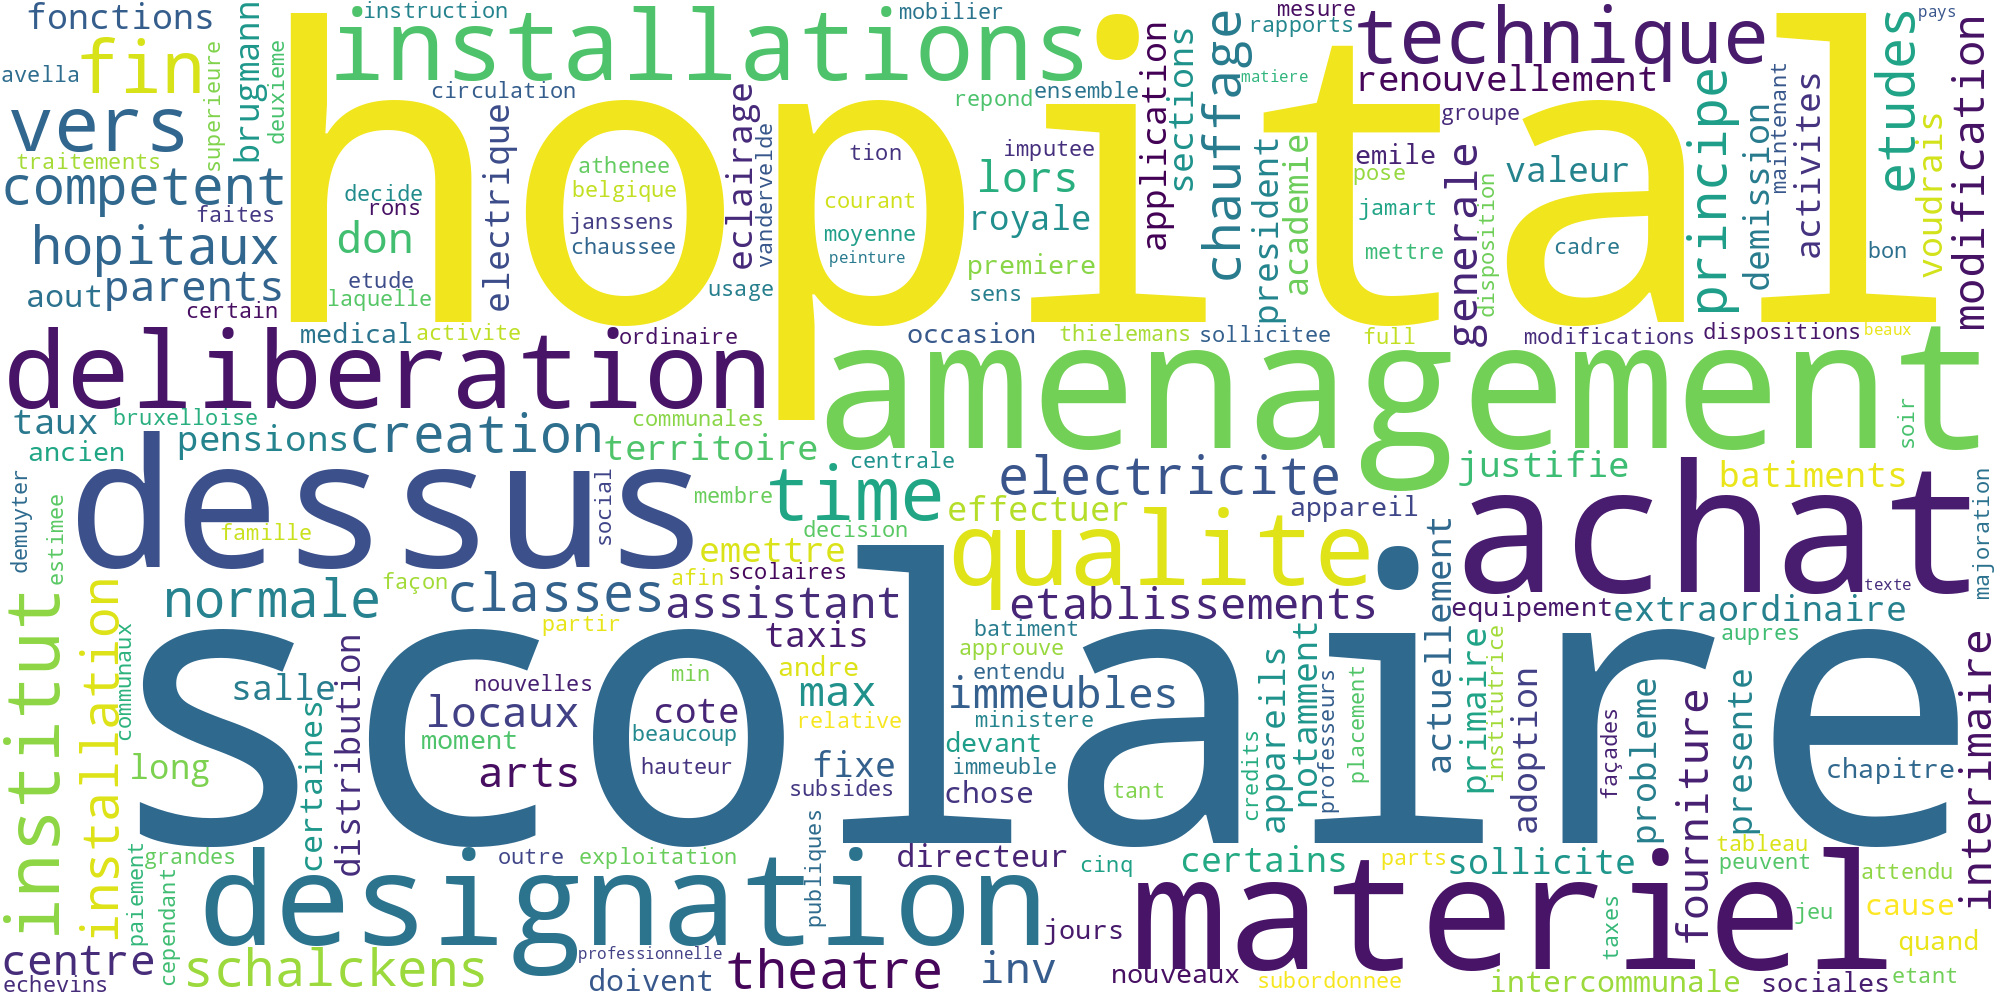

In [10]:
#creation du nuage de mot avec les 200 mots les plus fréquents

with open(fileout, 'r') as f:
    after = f.read()
    
frequencies = Counter(after.split())
print(frequencies.most_common(200))

cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(frequencies)
cloud.to_file(os.path.join(temp_path, "year.png"))
Image(filename=os.path.join(temp_path, "year.png"))